In [ ]:
'''
!pip install tokenizers
!pip install torchdata
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

from typing import Tuple
from torch import Tensor
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from copy import deepcopy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

In [4]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

f = open("parallelcorpus.txt", "a")

for i in train_iter:
  for x in [x.rstrip("\n") for x in i]:
    f.write(x)
    f.write(' ')

f.close()

In [5]:
MAX_LEN = 64
VOCAB_SIZE = 32768
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
BATCH_SIZE = 32

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train(['parallelcorpus.txt'], trainer)

tokenizer.enable_padding(pad_id=1, length=MAX_LEN)
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_enc = tokenizer.encode(src_sample.rstrip("\n"))
        src_batch.append(torch.tensor(src_enc.ids))

        tgt_enc = tokenizer.encode(tgt_sample.rstrip("\n"))
        tgt_batch.append(torch.tensor(tgt_enc.ids))
    return torch.stack(src_batch), torch.stack(tgt_batch)

In [6]:
test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)

In [7]:
class Embedding(nn.Module):
    def __init__(self, vocab_size=32678, d_model=512, pad_mask=1):
        super(Embedding, self).__init__()
        self.d_model = d_model
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=pad_mask)

    def forward(self, x):
        x = x.to(device)
        return self.emb(x) * math.sqrt(self.d_model)

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.d_ff = d_ff
        self.d_k = self.d_v = int(d_model / d_h)
        self.dropout = nn.Dropout(dropout)
        self.Linear = nn.Linear(d_model, d_model) # Linear Layer for the concatenated head
        self.normalize = nn.LayerNorm(d_model) # Normalizing Layer
        self.feed_forward = nn.Sequential( # Feed Forward Layer
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)])

    def forward(self, x):
        heads = []
        for i in range(self.d_h):
            Q = self.linears[3*i](x) # Query Matrix
            K = self.linears[3*i + 1](x) # Key Matrix
            V = self.linears[3*i + 2](x) # Value Matrix
            scaledMatMul = Q @ K.transpose(-1, -2) / math.sqrt(self.d_k) # Matrix mul. of Q and K.T -> Scale
            soft = F.softmax(scaledMatMul, dim=-1)
            soft = self.dropout(soft)
            head =  soft @ V # Softmax
            heads.append(head) # A Single Head
        Z = self.Linear(torch.cat((heads), -1)) # Concatenated heads -> Linear Layer
        Z = self.normalize(x + Z) # Output of the First Add&Norm Layer
        Z = self.normalize(self.feed_forward(Z) + Z) # 1st Add&Norm -> Feed Forward -> 2nd Add&Norm
        return Z

In [9]:
class EncoderStack(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1, N=6):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList([EncoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Encoder Layer N Times

    def forward(self, x):
        for encoder in self.encoders:
            x = encoder(x)
        return x

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.d_k = self.d_v = int(self.d_model / self.d_h)
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)]) # linear layers
        self.firstLinear = nn.Linear(d_h * self.d_v, d_model) # linear layer for the concatenated head
        self.secondLinear = nn.Linear(d_h * self.d_model, d_model) # linear layer for the concatenated head(second multi-head attention)
        self.normalize = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential( # Feed Forward Layer
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, y, y_mask=None):
        heads1 = []
        heads2 = []

        # FIRST ATTENTION LAYER
        ''' Same as encoder, but here we have tgt(target) as the decoder's input '''
        for i in range(self.d_h):
            Q = self.linears[3*i](y) # Query Matrix
            K = self.linears[3*i+1](y) # Key Matrix
            V = self.linears[3*i+2](y) # Value Matrix
            scaledMat = Q @ K.transpose(-1, -2) / math.sqrt(self.d_k) # Matrix mul. of Q and K.T -> Scale
            if y_mask is not None:
                scaledMat = scaledMat.masked_fill(y_mask, -1e9)
            soft = F.softmax(scaledMat, dim=-1) # Softmax
            soft = self.dropout1(soft)
            head =  soft @ V
            heads1.append(head) # Appending a single head
        Z1 = self.firstLinear(torch.cat((heads1), dim=-1)) # Concatenated heads of the First Attention Layer
        Z1 = self.normalize(y + Z1) # First Normalizing Layer

        # SECOND ATTENTION LAYER
        ''' Attention layer, instead of V and K matrices, we use the output of the encoder '''
        for i in range(self.d_h):
            scaledMat = Z1 @ x.transpose(-1, -2) / math.sqrt(self.d_k) # Matrix mul. of Q and encoderOutput.T -> Scale
            soft = F.softmax(scaledMat, dim=-1) # Softmax
            soft = self.dropout2(soft)
            head = soft @ x
            heads2.append(head) # Appending a single head
        Z2 = self.secondLinear(torch.cat((heads2), dim=-1)) # Concatenated heads of the Second Attention Layer
        Z2 = self.normalize(Z1 + Z2) # Second Normalizing Layer
        Z2 = self.normalize(self.feed_forward(Z2) + Z2) # Feed Forward -> Normalize
        return Z2

In [11]:
class DecoderStack(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1, N=6):
        super(DecoderStack, self).__init__()
        self.decoders = nn.ModuleList([DecoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Decoder Layer N Times

    def forward(self, x, y, y_mask=None):
        for decoder in self.decoders:
            y = decoder(x, y, y_mask)
        return y

In [12]:
class Mask(nn.Module):
    def __init__(self):
        super(Mask, self).__init__()
    
    def forward(self, batch_size, seq_len1, seq_len2):
        mask = (torch.triu(torch.ones((batch_size, seq_len1, seq_len2), dtype=torch.int32), diagonal=1) == 1)
        return mask

In [13]:
class Positional_Encoding(nn.Module):
    def __init__(self, d_model=512, n=10000):
        super(Positional_Encoding, self).__init__()
        self.d_model = d_model
        self.n = n
    def forward(self, seq_len):
        P = torch.zeros(seq_len, self.d_model)
        for k in range(seq_len):
            for i in range(self.d_model // 2):
                denominator = math.pow(self.n, 2*i/self.d_model)
                P[k, 2*i] = math.sin(k/denominator)
                P[k, 2*i+1] = math.cos(k/denominator)
        return P

In [14]:
class ModelOutput(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(ModelOutput, self).__init__()
        self.linear = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

In [15]:
class Transformer(nn.Module):
    def __init__(self, d_model=512, d_h = 8, d_ff=2048, vocab_size=32768, dropout=0.1, num_coder_layers=6):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.linear = nn.Linear(d_model, vocab_size)
        self.generateProbs = ModelOutput(d_model, vocab_size)
        self.dropoutEnc = nn.Dropout(dropout)
        self.dropoutDec = nn.Dropout(dropout)
        self.embed = Embedding(vocab_size, d_model, pad_mask=1)
        self.positional = Positional_Encoding(self.d_model, 10000)
        self.masking = Mask()
        self.encoderStack = EncoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)
        self.decoderStack = DecoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)

    def forward(self, x: Tensor, y: Tensor):
        assert x.shape[0] == y.shape[0]
        batch_dim = x.shape[0]
        assert x.shape[1] == y.shape[1]
        seq_len = x.shape[1]

        y_mask = self.masking(batch_dim, seq_len, seq_len)

        x, y = self.embed(x), self.embed(y)

        pos_encoding = self.positional(seq_len)

        x = pos_encoding + x
        y = pos_encoding + y

        x, y = self.dropoutEnc(x), self.dropoutDec(y)

        encoderOutput = self.encoderStack(x)

        decoderOutput = self.decoderStack(encoderOutput, y, y_mask)

        probs = self.generateProbs(decoderOutput)

        return probs

In [16]:
model = Transformer(d_model=512, d_h=8, d_ff=2048, vocab_size=VOCAB_SIZE, dropout=0.3, num_coder_layers=3)

###################################################################
####################Training begins for epoc  1####################
###################################################################
Training is complete for epoch  1, average loss for epoch  1: 4.310
-------------------------------------------------------------------
Accuracy is 67.06 % for epoch  1


###################################################################
####################Training begins for epoc  2####################
###################################################################
Training is complete for epoch  2, average loss for epoch  2: 2.821
-------------------------------------------------------------------
Accuracy is 74.34 % for epoch  2


###################################################################
####################Training begins for epoc  3####################
###################################################################
Training is complete for epoch  3, average los

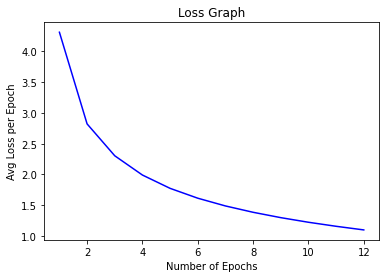



Accuracy Graph: 


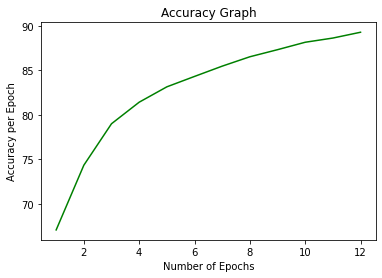

In [17]:
def train_and_eval(model: nn.Module, train_data: DataLoader, test_data: DataLoader, learning_rate: int, padding_idx: int, epoch_num: int):

    criterion = nn.NLLLoss(ignore_index=padding_idx)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    graph_x_loss = []
    graph_y_loss = []
    graph_x_acc = []
    graph_y_acc = []

    for epoch in range(1, epoch_num+1):

        print("#"*67)
        print(f'{"#"*20}Training begins for epoc {epoch:>2}{"#"*20}')
        print("#"*67)

        loss_arr = []
        for i, (src, tgt) in enumerate(train_data):
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            probs = model(src, tgt).permute(0, 2, 1)
            loss = criterion(probs, tgt)
            loss_arr.append(loss.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.average(loss_arr)
        graph_x_loss.append(epoch)
        graph_y_loss.append(avg_loss)
        print(f'Training is complete for epoch {epoch:>2}, average loss for epoch {epoch:>2}: {avg_loss:>5.3f}')
        print("-"*67)

        acc_per_batch=0
        test_data_size=0
        for src_test, tgt_test in test_data:
            test_data_size+=1
            src_test, tgt_test = src_test.to(device), tgt_test.to(device)
            probs = model(src_test, tgt_test)
            pred = torch.argmax(probs, dim=2)
            pred_arr = pred.cpu().numpy()
            tgt_test_arr = tgt_test.cpu().numpy()
            similar_idx_ratio=0
            batch_size = tgt_test.shape[0]

            for i in range(batch_size):
                    
                pad_idx_count = np.sum(tgt_test_arr[i] == 1)
                sentence_len = tgt.shape[1] - pad_idx_count
                similar_idx_ratio += np.sum(pred_arr[i][:sentence_len]==tgt_test_arr[i][:sentence_len]) / sentence_len
        
            average_similar_idx = similar_idx_ratio / batch_size
            acc_per_batch += average_similar_idx
    
        total_acc = (acc_per_batch / test_data_size)*100
        graph_x_acc.append(epoch)
        graph_y_acc.append(total_acc)
        print(f'Accuracy is {total_acc:>5.2f} % for epoch {epoch:>2}')
        print("\n")
    print("Loss graph: ")
    plt.plot(graph_x_loss, graph_y_loss, color='blue')
    plt.title("Loss Graph")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Avg Loss per Epoch")
    plt.show()

    print("\n")

    print("Accuracy Graph: ")
    plt.plot(graph_x_acc, graph_y_acc, color='green')
    plt.title("Accuracy Graph")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy per Epoch")
    plt.show



train_and_eval(model, train_dataloader, test_dataloader, learning_rate=0.001, padding_idx=PAD_IDX, epoch_num=12)

In [18]:
torch.save(model.state_dict(), "modelparams.pth")
torch.save(model, "model.pth")

In [ ]:
model.load_state_dict(torch.load(map_location=torch.device('cpu'), f="modelparams.pth"))
model.eval()

In [19]:
src, tgt = next(iter(test_dataloader))
print(src.shape)
print(tgt.shape)

torch.Size([32, 64])
torch.Size([32, 64])


In [20]:
logits = model(src, tgt)
pred = torch.argmax(logits, dim=2)

In [21]:
for example in range(10):
    print(f"Example no {example}: ")
    pad_count = (tgt[example] == PAD_IDX).data.sum().item()
    sentence_len = tgt.shape[1] - pad_count
    print("#"*80)
    print("#German text: ", tokenizer.decode(src[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("#English translation: ", tokenizer.decode(tgt[example].cpu().numpy().squeeze()))
    print("#"*80)
    print("#Model translation: ", tokenizer.decode(pred[example][:sentence_len].cpu().numpy().squeeze()))
    print("#"*80)
    print("\n")

Example no 0: 
################################################################################
#German text:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
################################################################################
#English translation:  A group of men are loading cotton onto a truck
################################################################################
#Model translation:  A group of men are - girls onto a truck
################################################################################


Example no 1: 
################################################################################
#German text:  Ein Mann schläft in einem grünen Raum auf einem Sofa .
################################################################################
#English translation:  A man sleeping in a green room on a couch .
################################################################################
#Model translation:  A man sleeping in a green room on a co

In [ ]:
src, _ = next(iter(test_dataloader))
src = src[:1]
print(src.shape)

In [ ]:
def translate(model: nn.Module, source: Tensor, start_token: int, stop_token: int, seq_len: int):
    src_pos_enc = model.positional(source.shape[1]).unsqueeze(0)

    src_embedding = model.embed(source)

    encoderInput = src_embedding + src_pos_enc

    encoderOutput = model.encoderStack(encoderInput)

    sequence = torch.tensor([[start_token]], dtype=torch.int32)

    for _ in range(seq_len):
        embedded_sequence = model.embed(sequence)

        seq_pos_enc = model.positional(sequence.shape[1]).unsqueeze(0)

        decoderInput = embedded_sequence + seq_pos_enc

        decoderInputMask = model.masking(sequence.shape[0], sequence.shape[1], sequence.shape[1])
        decoderOutput = model.decoderStack(encoderOutput, decoderInput, decoderInputMask)

        raw_word = decoderOutput[:, -1, :]

        probs = model.generateProbs(raw_word)

        generated_word_id = torch.argmax(probs, dim=-1)
        generated_word_tensor = torch.tensor([[generated_word_id.item()]], dtype=torch.int32)

        sequence = torch.cat((sequence, generated_word_tensor), dim=1)

        if generated_word_id == stop_token:
            break
        
    print(sequence)

    translation_ids = sequence.cpu().numpy()

    translation = tokenizer.decode(translation_ids.squeeze())

    return translation


model.eval()
translation = translate(model=model, source=src, start_token=2, stop_token=EOS_IDX, seq_len=MAX_LEN)
print(translation)

In [ ]:
encoded_german = tokenizer.encode("Auf der Veranda spielt ein glücklicher Hund.")
german_id_arr = encoded_german.ids

german = torch.tensor(german_id_arr).unsqueeze(0)
print(german)
print(german.shape)

translation = translate(model, german, 2, 3, MAX_LEN)